In [ ]:
#| default_exp ce_method

In [ ]:
#| export
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrn
from jax import vmap
from isssm.importance_sampling import ess_pct
from isssm.lcssm import log_prob as log_prob_joint
import tensorflow_probability.substrates.jax.distributions as tfd
from jaxtyping import Float, Array, PRNGKeyArray
from typing import Tuple

In [ ]:
#|hide 
import jax
config = jax.config
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
config.update("jax_enable_x64", True)
import fastcore.test as fct
from isssm.lcssm import nb_lcssm, simulate_lcssm
from isssm.mode_estimation import mode_estimation
from isssm.importance_sampling import lcssm_importance_sampling
import matplotlib.pyplot as plt

# Cross-Entropy method

> [!CAUTION]
> this module is still under construction

The cross entropy method [@Rubinstein1997Optimization;@Rubinstein2004CrossEntropy] is a method for determining good importance sampling proposals. Given a parametric family of proposals $g_\theta(x)$ and target $p(x)$, the Cross-Entropy method aims at choosing $\theta$ such that the Cross Entropy 
$$
\mathcal H_{\text{CE}} \left( p \middle|\middle| g_{\theta} \right) = \int p(x) \log g_{\theta}(x) \mathrm d x
$$
is maximized. This is equivalent to minimizing the Kullback Leibler divergence between $p$ and $g_\theta$. As $H_\text{CE}$ is not analytically available, it is approximated by importance sampling itself, usually with a suitable proposal $g_{\hat\theta_0}$. Then the approximate optimization problem is solved, yielding $\hat \theta_1$. These steps are then iterated until convergence, using common random numbers to ensure convergence.

Considering the Cross-Entropy method with a Gaussian proposal $g_\theta$, we see that the optimal $\theta$ only depends on the first and second order moments of $p$, indeed the optimal Gaussian is the one that matches these moments. Unfortunately this approach is not feasible for the models we consider in this package as the dimensionality ($n \cdot m$) is likely too high to act on the joint distribution directly - matching means is feasible, but simulating from the distribution and evaluating the likelihood is infeasible. However, we can exploit the Markov structure of our models:

For the class of state space models treated in this package, it can be shown that the smoothing distribution, the target of our inference, $p(x|y)$, is again a Markov process, see Chapter 5 in [@Chopin2020Introduction], so it makes sense to approximate this distribution with a Gaussian Markov process.
For such a Gaussian Markov process it is known that the precision matrix $P$ of the joint distribution is sparse, indeed it is a block-tri-diagonal matrix.


## computation of Cholesky factor $L$ of $P$
[@Schafer2021Sparse] show that the centered Gaussian Markov process (more generally any Gaussian distribution with given sparsity) which minimizes the Kullback-Leibler divergence to a centered Gaussian with specified covariance matrix has an analytically and numerically tractable Cholesky decomposition that can be computed fast. Using this Cholesky decomposition we are able to evaluate the likelihood and simulate from this distribution.

Consider states $X_t$ consisting of $m$ states $X_{t,1}, \dots, X_{t, m}$. The $i$-th $v_{i}$ column of the KL-optimal Cholesky decomposition corresponding to $X_t$ can, by [@Schafer2021Sparse], be obtained by 
$$
v_{i} = \frac{1}{\lambda_{i}}\text{Cov} \left(X_{t,i}, \dots, X_{t,m}, X_{t+1, 1}, \dots, X_{t+1, m} \right)^{-1} e_{1}
$$
where $\lambda_i$ is the square root of the first entry of the matrix vector product on the right-hand side and $e_{1}$ is the first unit vector. If $t=n$, then it suffices to replace above covariance with $\text{Cov}\left(X_{t,i}, \dots, X_{t,m}\right)$. In our setup we replace the exact covariance by an importance sampling estimate with weights $w^i$, $i = 1, \dots, n$.

In [ ]:
# | export
def ce_cholesky_block(
    x: Float[Array, "N m"],  # samples of $X_t$
    x_next: Float[Array, "N m"],  # samples of $X_{t+1}$
    weights: Float[Array, "N"],  # $w$, need not be normalized
) -> Float[Array, "2*m m"]:  # Cholesky factor
    """Calculate the columns and section of rows of the Cholesky factor of $P$ corresponding to $X_t$, $t < n$."""
    _, m = x.shape
    joint_x = jnp.concatenate([x, x_next], axis=1)
    weights = weights / weights.sum()

    joint_mean = jnp.sum(joint_x * weights[:, None], axis=0)
    cov = jnp.atleast_2d(
        jnp.sum(
            (joint_x[:, :, None] @ joint_x[:, None, :]) * weights[:, None, None], axis=0
        )
        - joint_mean[:, None] @ joint_mean[None, :]
    )

    L = jnp.zeros((2 * m, m))
    for i in range(m):
        sub_cov = cov[i:, i:]
        v = jnp.linalg.solve(sub_cov, jnp.eye(2 * m - i)[0])
        lam = jnp.sqrt(v[0])
        L = L.at[i:, i].set(v / lam)

    return L


def ce_cholesky_last(
    x: Float[Array, "N m"],  # samples of $X_n$
    weights: Float[Array, "N"],  # $w$, need not be normalized
) -> Float[Array, "m m"]:  # Cholesky factor
    """Calculate the Cholesky factor of $P$ corresponding to $X_n$."""
    _, m = x.shape
    L = jnp.zeros((m, m))
    weights = weights / weights.sum()

    mean = jnp.sum(x * weights[:, None], axis=0)

    cov = jnp.atleast_2d(
        jnp.sum((x[:, :, None] @ x[:, None, :]) * weights[:, None, None])
        - mean @ mean.T
    )

    for i in range(m):
        sub_cov = cov[i:, i:]
        v = jnp.linalg.solve(sub_cov, jnp.eye(m - i)[0])
        lam = jnp.sqrt(v[0])
        L = L.at[i:, i].set(v / lam)
    return L


def cholesky_components(
    samples: Float[Array, "N n m"],  # samples of $X_1, \ldots, X_n$
    weights: Float[Array, "N"],  # $w$, need not be normalized
) -> Tuple[
    Float[Array, "n m m"], Float[Array, "n m m"]
]:  # block diagonal and off-diagonal components
    """calculate all components of the Cholesky factor of $P$"""
    current = samples[:, :-1]
    next = samples[:, 1:]

    diag, off_diag = jnp.split(
        vmap(ce_cholesky_block, (1, 1, None))(current, next, weights), 2, 1
    )
    last_diag = ce_cholesky_last(samples[:, -1], weights)
    full_diag = jnp.concatenate([diag, last_diag[None, :]], axis=0)

    return full_diag, off_diag

## running example: AR(1) process

we'll use the simples non-degenerate Gaussian Markov process as an example, an AR(1) process. We start this process in its stationary distribution.

In [ ]:
a = 1/2
s2 = 1.

n = 10
# stationary
tau2 = s2 / (1 - a**2)

cov = jnp.array([[
    tau2 * a**(jnp.abs(i - j))
    for j in range(n)
] for i in range(n)])

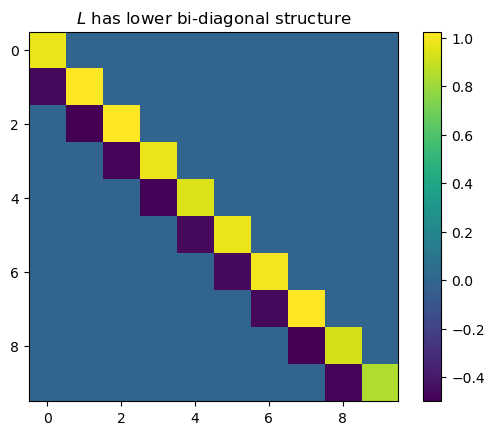

In [ ]:
N = 1000
samples = MVN(jnp.zeros(n), cov).sample((1000,), seed=jrn.PRNGKey(5324523423))[...,None]
weights = jnp.ones(N)
samples.shape

diag, off_diag = cholesky_components(samples, weights)
P = jnp.linalg.inv(cov)
L = jnp.diag(jnp.concatenate(diag)[:,0]) + jnp.diag(jnp.concatenate(off_diag)[:,0], -1)
plt.title("$L$ has lower bi-diagonal structure")
plt.imshow(L)
plt.colorbar()
plt.show()

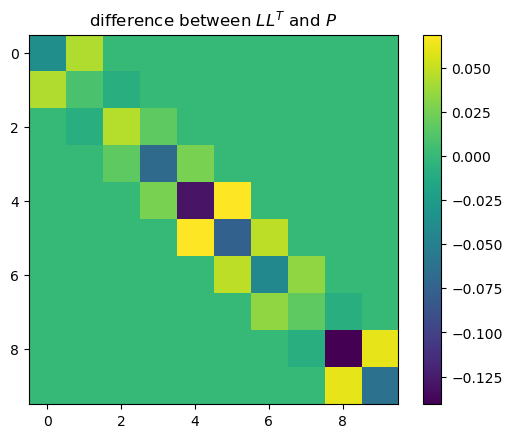

In [ ]:
plt.title("difference between $L L^T$ and $P$")
plt.imshow(L @ L.T - P)
plt.colorbar()
plt.show()

In [ ]:
#| hide
fct.test_close(L @ L.T, P, .5)

## simulation using $L$

As $LL^T = P = \Sigma^{-1}$, $L^{-T}L^{-1} = \Sigma$ so to simulate $X \sim \mathcal N(0, \Sigma)$ it suffices to simulate a standard normal $Z \sim \mathcal N(0, I)$ and solve $L^T X = Z$. Luckily, $L^T$ is an upper block diagonal matrix which solving this system of equations straightforward. To this end we partition $X = (X_1^{T}, \dots, X_n^{T})^{T}$ and $Z = (Z_1^{T}, \dots, Z_n^{T})^{T}$ and $L = \text{block-diag} \left( L_{1,1}, \dots, L_{n,n} \right) + \text{lower-block-off-diag} \left( L_{2,1}, \dots, L_{n, n-1} \right)$. Starting with $X_n$, we solve
$$
L_{n,n}^T X_{n} = Z_{n}
$$
by using the fact that $L_{n,n}^T$ is an upper triangular matrix. We then iteratively solve for $i = n-1, \dots, 1$
$$
L_{i,i}^TX_{i} + L_{i+1,i}^T X_{i + 1} = Z_{i},
$$
so
$$
X_{i} = L_{i,i}^{-T} \left( Z_{i} - L_{i +1, i}^{T} X_{i + 1} \right).
$$

In [ ]:
vsolve_t = vmap(jsp.linalg.solve_triangular, (None, 0))
vmm = vmap(jnp.matmul, (None, 0))

def simulate(
        full_diag: Float[Array, "n m m"], # block diagonals of $L$
        off_diag: Float[Array, "n-1 m m"], # off-diagonals of $L$
        key: PRNGKeyArray, # random key
        N: int # number of samples
        ) -> Float[Array, "N n m"]: # $N$ samples of $X_1, \ldots, X_n$
    """Simulate from Markov process with Cholesky factor $L$."""
    n, m, _ = full_diag.shape

    key, subkey = jrn.split(key)
    x = jnp.zeros((N, n, m))
    z_n = jrn.normal(subkey, shape=(N, m))
    x_n = vsolve_t(full_diag[-1].T, z_n)

    x = x.at[:, -1].set(x_n)

    for i in range(n - 1):
        key, subkey = jrn.split(key)
        z = jrn.normal(subkey, shape=(N, m))
        new_x = vsolve_t(
            full_diag[n - i - 2].T,
            z - vmm(off_diag[n - i - 2], x[:, n - i - 1])
        )
        x = x.at[:, n - i - 2].set(new_x)
    return x

## Evaluating the density

Similar to simulation, we can evaluate the log-density 
$$
\log p(x) = - \frac{n\cdot m}{2}  \log(2  \pi) - \frac{1}{2} \log \det \Sigma - \frac 1 2 (x - \mu)^{T} \Sigma^{-1}(x-\mu)
$$
efficiently using $L$.

For the $\log\det \Sigma$-term notice that $\Sigma = L^{-T}L^{-1}$ results in $2 \log\det L = 2 \sum_{i = 1}^n \log\det L_{i,i}$. These determinants are simply the product of the diagonal entries, as $L$ is a lower triangular matrix.

The quadratic part can be rewritten as $\lVert L^T(x-\mu) \rVert^{2}$ and, using the structure of $L^{T}$, this consists of terms of the form $L^T_{i,i} (x_i - \mu_i) + L^T_{i+1, i}(x_{i + 1} - \mu_{i + 1})$.

In [ ]:
#| export
def log_prob(
    x: Float[Array, "n+1 m"], # the location at which to evaluate the likelihood
    full_diag: Float[Array, "n+1 m m"],# block diagonals of $L$
    off_diag: Float[Array, "n m m"], # off-diagonals of $L$
    mean: Float[Array, "n+1 m"], # mean of the process
) -> Float: # log-likelihood
    np1, m = x.shape

    # append zeros to have the same shape as full_diag
    extended_off_diag = jnp.concatenate([off_diag, jnp.zeros((m, m))[None]], axis=0)
    centered = x - mean

    # L is triangular
    logdet = 2 * jnp.sum(jnp.log(vmap(jnp.diag)(full_diag)))

    # exploit sparsity of L
    extended_centered = jnp.concatenate([centered, jnp.zeros((1, m))], axis=0)
    Lt_x = (
        full_diag.transpose((0, 2, 1)) @ extended_centered[:-1,:,None]
        + extended_off_diag.transpose((0, 2, 1)) @ extended_centered[1:,:,None]
    )[:,:,0]
    l2_norm = jnp.sum(Lt_x ** 2)

    return -np1 * m / 2 * jnp.log(2 * jnp.pi) - 1 / 2 * logdet - 1 / 2 * l2_norm

In [ ]:
#| hide
#log-det part
actual = log_prob(jnp.zeros((10,1)), jnp.ones((10,1,1)), jnp.ones((9,1,1)), jnp.zeros((10,1)))
expected = - 10/2 * jnp.log(2 * jnp.pi) 
fct.test_close(actual, expected)
# l2 norm part
actual = log_prob(jnp.ones((10,1)), jnp.ones((10,1,1)), jnp.ones((9,1,1)), jnp.zeros((10,1)))
expected = - 10/2 * jnp.log(2 * jnp.pi) - 1/2 * (9 * 4 + 1)
fct.test_close(actual, expected)

In [ ]:
#| hide
def kl_optimal_rev_time_markov_process(samples):
    N, n, m = samples.shape
    current = samples[:,:-1]
    next = samples[:,1:]

    diag, off_diag = jnp.split(
        vmap(ce_cholesky_block, (1, 1))(current, next),
        2, 1
    )
    last_diag = ce_cholesky_last(samples[:,-1])
    full_diag = jnp.concatenate([diag, last_diag[None,:]], axis=0)

    long_eye = jnp.tile(jnp.eye(m), (n,1,1))
    innov_chol = jsp.linalg.solve_triangular(full_diag.transpose((0,2,1)), long_eye, lower=False)
    reverse_transitions = - innov_chol[:-1] @ jnp.linalg.solve(off_diag.transpose((0,2,1)), long_eye[:-1])

    return innov_chol, reverse_transitions


## Example: AR(1) process with NB observations

In [ ]:
# model setup
m, p, np1 = 1, 1, 1000
A = jnp.broadcast_to(jnp.eye(m), (np1, m, m))
B = jnp.broadcast_to(jnp.eye(m), (np1 + 1, p, m))

s2= 0.01
Sigma = jnp.broadcast_to(s2 * jnp.eye(m), (np1 + 1, m, m))
x0 = jnp.ones(m)

*_, dist, xi = nb_lcssm(x0, A, Sigma, B, 10.)

# simulate from model
key = jrn.PRNGKey(51)
key, subkey = jrn.split(key)
N = 1
(x_true, ), (y,) = simulate_lcssm(x0, A, Sigma, B, dist, xi, N, subkey)

# laplace approximation & importance sampling
s_init = jnp.log(y + 1.)
x_smooth, z, Omega = mode_estimation(y, x0, A, Sigma, B, dist, xi, s_init, 10)

N = 1000
key, subkey = jrn.split(key)
samples, lw = lcssm_importance_sampling(y, x0, A, Sigma, B, dist, xi, z, Omega, N, subkey)

weights = jnp.exp(lw - jnp.max(lw))
ess_pct(lw)

Array(53.07772878, dtype=float64)

In [ ]:
diag, off_diag = cholesky_components(samples, weights)
mean = jnp.sum(samples * weights[:,None,None], axis=0) /jnp.sum(weights)
key, subkey = jrn.split(key)
x = simulate(diag, off_diag, subkey, N) + mean

## Importance Sampling

For importance sampling with this model the log weights read 
$$
\log w(x) = \log p(x|y) - \log g(x) = \log p(x,y) - \log g(x) - \log p(y),
$$
where we ignore the $\log p(y)$ term to obtain autonormailsed importance sampling weights.


In [ ]:
#| export
def ce_log_weights(
    x: Float[Array, "n+1 m"], # the sample
    y: Float[Array, "n+1 p"], # the observations
    full_diag: Float[Array, "n+1 m m"],# block diagonals of $L$
    off_diag: Float[Array, "n m m"], # off-diagonals of $L$
    mean: Float[Array, "n+1 m"], # mean of the process
    x0: Float[Array, "m"], # initial state
    A: Float[Array, "n m m"], # transition matrix
    Sigma: Float[Array, "n+1 m m"], # covariance matrix
    B: Float[Array, "n+1 p m"], # observation matrix
    dist: tfd.Distribution, # distribution of the initial state
    xi: Float[Array, "n+1 m"], # initial state
) -> Float: # log-weights
    log_p = log_prob_joint(x, y, x0, A, Sigma, B, dist, xi)
    log_g = log_prob(x, full_diag, off_diag, mean)

    return log_p - log_g

In [ ]:
N = 10000
key, subkey = jrn.split(key)
samples, log_weights = lcssm_importance_sampling(y, x0, A, Sigma, B, dist, xi, z, Omega, N, subkey)
weights = jnp.exp(log_weights - jnp.max(log_weights))


for i in range(10):
    mean = jnp.sum(samples * weights[:,None,None], axis=0) / jnp.sum(weights)
    diag, off_diag = cholesky_components((samples - mean), weights)

    samples = simulate(diag, off_diag, subkey, N) + mean

    log_weights = vmap(ce_log_weights, (0, *(None,)*10))(samples, y, diag, off_diag, mean, x0, A, Sigma, B, dist, xi)
    weights = jnp.exp(log_weights - jnp.max(log_weights))

ess_pct(log_weights)

Array(0.02111013, dtype=float64)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()